# Mark-ICP tester

In [1]:
import os
import sys
import cv2
import copy
sys.path.append(os.path.join(os.path.join(
    os.environ["RNB_PLANNING_DIR"], 'src')))
sys.path.append(os.path.join(
    os.environ["RNB_PLANNING_DIR"], 'src/scripts/demo_202107'))
sys.path.append(os.path.join(
    os.environ["RNB_PLANNING_DIR"], 'src/scripts/milestone_202110'))

from pkg.global_config import RNB_PLANNING_DIR
from pkg.utils.utils import *    
from pkg.utils.rotation_utils import *
from pkg.controller.combined_robot import *
from pkg.geometry.builder.scene_builder import SceneBuilder
from pkg.geometry.geometry import GeometryItem
from pkg.geometry.geotype import GEOTYPE

from demo_utils.environment import *

from utils.detection_util import *

from util.multiICP import *
from test_util import *

In [2]:
crob = CombinedRobot(robots_on_scene=[RobotConfig(0, RobotType.indy7, 
                           ((0,0,0), (0,0,0)),None)]
              , connection_list=[False])

s_builder = SceneBuilder(None)
gscene = s_builder.create_gscene(crob)
viewpoint = add_cam(gscene, tool_link="indy0_tcp")
VIEW_POSE = np.deg2rad([  0., 50.,  -70.,  -0.,  -90., 0])
gscene.show_pose(VIEW_POSE)
Tbc = viewpoint.get_tf(VIEW_POSE)

connection command:
indy0: False
Please create a subscriber to the marker
publication OK
published: [0, 0, 0, 0, 0, 0]
Please create a subscriber to the marker


### Get ICP result

In [3]:
color_image = cv2.imread(os.path.join(os.getcwd(), "save_img/bed/color/color_19.jpg"), flags=cv2.IMREAD_UNCHANGED)
depth_mask = cv2.imread(os.path.join(os.getcwd(), "save_img/bed/depth_segmented/depth_mask_19.png"), flags=cv2.IMREAD_UNCHANGED)

cdp = ColorDepthMap(color_image, depth_mask, 
                    [1280, 720,
                     899.05322266, 899.21044922,
                     654.88366699, 352.92956543], 
                    0.000250000011874)
cameraMatrix = np.array([[cdp.intrins[2], 0, cdp.intrins[4]],
                         [0, cdp.intrins[3], cdp.intrins[5]],
                         [0, 0, 1]])
distCoeffs = np.array([ 0.15870179, -0.46903715, -0.0014261 ,  0.00066797,  0.41631824])

icp_bed = MultiICP(model=MODEL_DIR + '/bed/bed.STL', 
                   Toff=SE3([[0,1,0],[0,0,1],[1,0,0]], [0.455,0,1.02]))

icp_bed.clear()
pcd_bed = icp_bed.add_image(cdp, Tc=None)


### Show on RVIZ

In [4]:
gscene.create_safe(GEOTYPE.MESH, "bed_pcd", "base_link", (0.1,0.1,0.1), (0,0,0), rpy=(0,0,0), color=(1,0,0,1), display=True,
                   collision=False, fixed=True, scale=(0.01,0.01,1),
                   vertices=np.matmul(np.asarray(pcd_bed.points), Tbc[:3,:3].transpose())+Tbc[:3,3])

[WARN] Vertices for mesh should be have center point (0,0,0). Auto adjusting.


### Compute ICP

In [5]:
T_cb = SE3_inv(Tbc)
Tguess = icp_bed.get_initial_by_center(R=np.matmul(T_cb[:3,:3], Rot_axis(3,np.pi)), 
                                               offset=np.matmul(T_cb[:3,:3], (1.1*0.7,0,-0.6)))


# ICP_result, fitness = icp_bed.compute_ICP(To=SE3(Rot_axis_series([3, 2],[-np.pi/2, np.pi/2]), (0,0,3)), visualize=True)
T_co1, fitness1 = icp_bed.compute_ICP(To=Tguess, thres=0.15, visualize=False)
T_co2, fitness2 = icp_bed.compute_front_ICP(Tc_cur=np.identity(4), To=T_co1, thres=0.1, visualize=False)
Tdetect=np.matmul(Tbc, T_co2)

Apply point-to-point ICP
registration::RegistrationResult with fitness=6.468542e-01, inlier_rmse=6.349042e-02, and correspondence_set size of 28263
Access transformation to get result.
Transformation is:
[[ 0.82025505  0.05538427 -0.56931031 -0.24082231]
 [ 0.10579382 -0.99281889  0.05584189  0.71304235]
 [-0.56212927 -0.1060341  -0.82022402  4.13780281]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=5.748637e-01, inlier_rmse=3.790797e-02, and correspondence_set size of 12551
Access transformation to get result.
Transformation is:
[[ 0.82577909  0.02795051 -0.56330068 -0.27013314]
 [ 0.04472815 -0.99887095  0.01600676  0.8042845 ]
 [-0.56221729 -0.03841345 -0.82609692  4.13211607]
 [ 0.          0.          0.          1.        ]]


### Visualize and adjust
* Adjust Tdetect to get perfect GT

In [6]:
bed = add_bed(gscene, Tdetect[:3,3], Rot2rpy(Tdetect[:3,:3]), (0,1,0,0.5))

In [7]:
# for left
T_bo_gt = matmul_series(Tdetect, 
                        SE3(np.identity(3), (0.01,0.04,0.043)),
                        SE3(Rot_axis(1, -0.015), (0,0.0,0)),
                        SE3(Rot_axis(2, 0.055), (0,0.0,0)),
                        SE3(Rot_axis(3, -0.015), (0,0.0,0))
                       )

# # for right
# T_bo_gt = matmul_series(Tdetect, 
#                         SE3(np.identity(3), (0.02,-0.01,0.01)),
#                         SE3(Rot_axis(1, 0.03), (0,0.0,0)),
#                         SE3(Rot_axis(2, 0.01), (0,0.0,0)),
#                         SE3(Rot_axis(3, 0.005), (0,0.0,0))
#                        )

In [8]:
move_bed(gscene, bed_center=T_bo_gt[:3,3], 
         bed_rpy=Rot2rpy(T_bo_gt[:3,:3]))

### Mask for closet from bed

In [7]:
color_image = cv2.imread(os.path.join(os.getcwd(), "save_img/bed/color/color_19.jpg"), flags=cv2.IMREAD_UNCHANGED)
depth_image = cv2.imread(os.path.join(os.getcwd(), "save_img/bed/depth/depth_19.png"), flags=cv2.IMREAD_UNCHANGED)

cdp = ColorDepthMap(color_image, depth_image, 
                    [1280, 720,
                     899.05322266, 899.21044922,
                     654.88366699, 352.92956543], 
                    0.000250000011874)

In [8]:
CLOSET_LOCATION = "LEFT"
icp_closet = MultiICP(model=MODEL_DIR + '/top_table/top_table.STL', 
                      Toff=SE3([[1,0,0],[0,0,1],[0,-1,0]], [0.3,0,0.2725]))
icp_closet.clear()

pcd_closet = cdp2pcd(cdp, Tbc)

pcd_masked = mask_boxes(pcd_closet, 
                    boxes=[gscene.NAME_DICT["bed_{}_space".format(CLOSET_LOCATION.lower())]], 
                    Q=VIEW_POSE, inside=True, 
                    merge_rule=np.all, link_ref="base_link")
pcd_masked = mask_boxes(pcd_masked, 
                    boxes=[gscene.NAME_DICT["bed_box"], 
                           gscene.NAME_DICT["bed_wall"]], 
                    Q=VIEW_POSE, inside=False, 
                    merge_rule=np.all, link_ref="base_link")
pcd_masked, ind = pcd_masked.remove_radius_outlier(nb_points=20, radius=0.06)
pcd_closet = icp_closet.add_pointcloud(pcd_masked, Tbc, ratio=0.5)

### Show on Rviz

In [9]:
gscene.create_safe(GEOTYPE.MESH, "closet_pcd", "base_link", (0.1,0.1,0.1), (0,0,0), rpy=(0,0,0), color=(1,0,0,1), display=True,
                   collision=False, fixed=True, scale=(0.01,0.01,1),
                   vertices=np.asarray(pcd_closet.points))

[WARN] Vertices for mesh should be have center point (0,0,0). Auto adjusting.


### Compute front ICP

In [10]:
bed_vis = gscene.NAME_DICT["bed_vis"]
Tbs = bed_vis.get_tf(VIEW_POSE)
initial_guess = icp_closet.get_initial_by_median(Tbs[:3, :3], np.matmul(Tbc[:3,:3], (0,0,0.3))-(0,0,1))
T_bo_closet, fitness = icp_closet.compute_front_ICP(Tbc, initial_guess, thres=0.1, visualize=True)

Apply point-to-point ICP
registration::RegistrationResult with fitness=8.000183e-01, inlier_rmse=3.373968e-02, and correspondence_set size of 8745
Access transformation to get result.
Transformation is:
[[-8.16287609e-01  3.07050817e-01  4.89279414e-01  3.86088362e+00]
 [ 5.14219622e-01  3.79436963e-04  8.57658442e-01  3.99491592e-01]
 [ 2.63159089e-01  9.51693043e-01 -1.58201283e-01 -1.34688338e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


### Visualize and adjust

In [11]:
closet_leftup, closet_rightup, closet_down = add_closet(
    gscene, closet_center=T_bo_closet[:3,3], closet_rpy=Rot2rpy(T_bo_closet[:3,:3]), 
    COLOR_CLOSET_COL=(0,1,0,0.3))

In [12]:
z_offset = np.matmul(SE3_inv(Tdetect),T_bo_closet)[2,3]
T_bo_closet_new = np.matmul(T_bo_closet,
                            SE3(np.identity(3), (0,0,-z_offset)))
move_closet(gscene, closet_center=T_bo_closet_new[:3,3], 
         closet_rpy=Rot2rpy(T_bo_closet_new[:3,:3]))

In [27]:
# for left
# T_bo_gt = matmul_series(T_bo_closet_new, 
#                         SE3(np.identity(3), (-0.015,-0.00,0.03)),
#                         SE3(Rot_axis(1, 0.005), (0,0.0,0)),
#                         SE3(Rot_axis(2, 0.0), (0,0.0,0)),
#                         SE3(Rot_axis(3, -0.02), (0,0.0,0))
#                        )

# for right
T_bo_gt = matmul_series(T_bo_closet_new, 
                        SE3(np.identity(3), (-0.0,-0.04,0.0)),
                        SE3(Rot_axis(1, -0.04), (0,0.0,0)),
                        SE3(Rot_axis(2, -0.0), (0,0.0,0)),
                        SE3(Rot_axis(3, 0.00), (0,0.0,0))
                       )

In [28]:
move_closet(gscene, closet_center=T_bo_gt[:3,3], 
         closet_rpy=Rot2rpy(T_bo_gt[:3,:3]))

### for toilet

In [3]:
color_image = cv2.imread(os.path.join(os.getcwd(), "save_img/toilet/color/color_1.jpg"), flags=cv2.IMREAD_UNCHANGED)
depth_mask = cv2.imread(os.path.join(os.getcwd(), "save_img/toilet/depth_segmented/depth_mask_1.png"), flags=cv2.IMREAD_UNCHANGED)

cdp = ColorDepthMap(color_image, depth_mask, 
                    [1280, 720,
                     899.05322266, 899.21044922,
                     654.88366699, 352.92956543], 
                    0.000250000011874)
cameraMatrix = np.array([[cdp.intrins[2], 0, cdp.intrins[4]],
                         [0, cdp.intrins[3], cdp.intrins[5]],
                         [0, 0, 1]])
distCoeffs = np.array([ 0.15870179, -0.46903715, -0.0014261 ,  0.00066797,  0.41631824])

icp_toilet = MultiICP(model='model_CAD/toilet_big.STL', 
                   Toff=SE3(np.identity(3),(0,0,0)), scale=[1.24e-2,1e-2,1.05e-2])

icp_toilet.clear()
pcd_toilet = icp_toilet.add_image(cdp, Tc=None)


In [4]:
gscene.create_safe(GEOTYPE.MESH, "toilet_pcd", "base_link", (0.1,0.1,0.1), (0,0,0), rpy=(0,0,0), color=(1,0,0,1), display=True,
                   collision=False, fixed=True, scale=(0.01,0.01,1),
                   vertices=np.matmul(np.asarray(pcd_toilet.points), Tbc[:3,:3].transpose())+Tbc[:3,3])

[WARN] Vertices for mesh should be have center point (0,0,0). Auto adjusting.


In [5]:
scale=[1.24e-2,1.23e-2,1.05e-2]
toilet_model = o3d.io.read_triangle_mesh('model_CAD/toilet_big.STL')
toilet_model.vertices = o3d.utility.Vector3dVector(
                np.asarray(toilet_model.vertices) * np.array([scale[0], scale[1], scale[2]]))

toilet_pcd = toilet_model.sample_points_uniformly(int(len(np.asarray(icp_toilet.pcd.points))*0.7))
points = np.asarray(toilet_pcd.points)

idx = []
for i in range(len(points)):
    if points[i, 2] < 0.4:
        idx.append(i)

pts = np.zeros((len(idx), 3))
for i in range(len(idx)):
    pts[i] = points[idx[i]]

cut_pcd = o3d.geometry.PointCloud()
cut_pcd.points = o3d.utility.Vector3dVector(pts)
icp_toilet.model_sampled = cut_pcd

T_cb = SE3_inv(Tbc)
Tguess = icp_toilet.get_initial_by_center(R=matmul_series(Rot_axis(1, -np.pi/2), T_cb[:3,:3], Rot_axis(3,np.pi/2)), 
                                               offset=np.matmul(T_cb[:3,:3], (-0.2,-0.2,-0.3)))

T_co1, fitness1 = icp_toilet.compute_ICP(To=Tguess, thres=0.13, visualize=True)
# T_co2, fitness2 = icp_bed.compute_front_ICP(Tc_cur=np.identity(4), To=T_co1, thres=0.1, visualize=False)
Tdetect=np.matmul(Tbc, T_co1)

Apply point-to-point ICP
registration::RegistrationResult with fitness=9.930725e-01, inlier_rmse=4.589788e-02, and correspondence_set size of 40282
Access transformation to get result.
Transformation is:
[[-0.99741653  0.02244709 -0.06823778  0.38417956]
 [ 0.00447428 -0.92866677 -0.37088813  0.40969989]
 [-0.07169552 -0.37023527  0.92616715  1.37578709]
 [ 0.          0.          0.          1.        ]]


In [6]:
def add_toilet(gscene, toilet_center, toilet_rpy, COLOR_TOILET_COL):
    toilet = gscene.create_safe(GEOTYPE.MESH, "toilet_vis", link_name="base_link",
                             dims=(0.1,0.1,0.1), center=toilet_center, rpy=toilet_rpy,
                             color=(0.8,0.8,0.8,1), display=True, fixed=True, collision=False,
                             uri="package://my_mesh/meshes/stl/toilet_big.STL", scale=(1.24e-2,1.23e-2,1.05e-2))

    return toilet
toilet = add_toilet(gscene, Tdetect[:3,3], Rot2rpy(Tdetect[:3,:3]), (0,1,0,0.5))

In [252]:
T_bo_gt = matmul_series(Tdetect, 
                        SE3(np.identity(3), (0.15,-0.01,-0.07)),
                        SE3(Rot_axis(1, 0.04), (0,0.0,0)),
                        SE3(Rot_axis(2, -0.65), (0,0.0,0)),
                        SE3(Rot_axis(3, 0.05), (0,0.0,0))
                       )

In [253]:
toilet = add_toilet(gscene, T_bo_gt[:3,3], Rot2rpy(T_bo_gt[:3,:3]), (0,1,0,0.5))

In [254]:
gscene.add_highlight_axis("hl", "toilet", T=T_bo_gt)

# Make ArucoMap for Testing

### Testing single marker
* Make single-marker aruco map to get one-marker transformation

In [255]:
from cv2 import aruco
from pkg.detector.aruco.detector import *

def get_aruco_map_test(test_name, mk_idx, mk_size, point=[0,0,0], direction=(0,0,0)):
    dictionary = aruco.getPredefinedDictionary(aruco.DICT_6X6_250)
    #     params = aruco.DetectorParameters_create()

    aruco_map = ArucoMap(dictionary=dictionary, _dict={
        test_name: MarkerSet(test_name,
                         dlevel=DetectionLevel.ENVIRONMENT, gtype=GEOTYPE.BOX, dims=(0.1, 0.1,0.1), color=(0.8,0.0,0.0,1),
                         _list=[
                             ObjectMarker(test_name, mk_idx, mk_size, point, direction)
                         ])
    })
    return aruco_map

In [20]:
# for bed
mk_idx = 230
mk_size = 0.15
aruco_map = get_aruco_map_test("bed_test", mk_idx, mk_size)
objectPose_dict, corner_dict = aruco_map.get_object_pose_dict(color_image, cameraMatrix, distCoeffs)
Tbmark = objectPose_dict['bed_test']
Tbmark = np.matmul(Tbc, Tbmark)

In [39]:
# for closet
mk_idx = 235
mk_size = 0.15
aruco_map = get_aruco_map_test("closet_test", mk_idx, mk_size)
objectPose_dict, corner_dict = aruco_map.get_object_pose_dict(color_image, cameraMatrix, distCoeffs)
Tbmark = objectPose_dict['closet_test']
Tbmark = np.matmul(Tbc, Tbmark)

In [271]:
# for toilet
mk_idx = 232
mk_size = 0.15
aruco_map = get_aruco_map_test("toilet_test", mk_idx, mk_size)
objectPose_dict, corner_dict = aruco_map.get_object_pose_dict(color_image, cameraMatrix, distCoeffs)
Tbmark = objectPose_dict['toilet_test']
Tbmark = np.matmul(Tbc, Tbmark)

### Show marker location on RVIZ

In [272]:
gscene.add_highlight_axis("hl", "mark_{}".format(mk_idx), T=Tbmark)

### Get relative marker offset

In [273]:
Tmark = np.matmul(SE3_inv(T_bo_gt), Tbmark)

point = Tmark[:3,3]
direction = Rot2rpy(Tmark[:3,:3])
print("point: {}, {}, {}".format(*point))
print("direction: {}, {}, {}".format(*direction))

point: 0.105553045934, 0.61795361593, 0.485479704806
direction: -0.323776064386, 0.0938069048613, -3.01927412346


### Visualize result

In [28]:
# # for bed
# aruco_map = get_aruco_map_test("test_bed", mk_idx, mk_size, point=point, direction=direction)
# objectPose_dict, corner_dict = aruco_map.get_object_pose_dict(color_image, cameraMatrix, distCoeffs)
# Tbed = objectPose_dict['test_bed']
# Tbed = np.matmul(Tbc, Tbed)

In [ ]:
# # for closet
# aruco_map = get_aruco_map_test("test_closet", mk_idx, mk_size, point=point, direction=direction)
# objectPose_dict, corner_dict = aruco_map.get_object_pose_dict(color_image, cameraMatrix, distCoeffs)
# Tcloset = objectPose_dict['test_closet']
# Tcloset = np.matmul(Tbc, Tcloset)

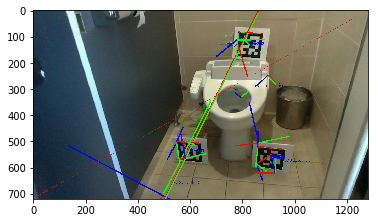

In [8]:
# total markerset test
from pkg.detector.aruco.marker_config import get_aruco_map
import matplotlib.pyplot as plt
aruco_map_total = get_aruco_map()
obj_dict, corner_dict = aruco_map_total.get_object_pose_dict(color_image, cameraMatrix, distCoeffs)
img_out = aruco_map_total.draw_objects(color_image, obj_dict, corner_dict, cameraMatrix, distCoeffs)
plt.imshow(img_out[:,:,[2,1,0]])

# Tbed = obj_dict['test_bed_right']
# Tbed= matmul_series(Tbc, Tbed)

# Tcloset = obj_dict['test_closet_right']
# Tcloset= matmul_series(Tbc, Tcloset)

Ttoilet = obj_dict['test_toilet']
Ttoilet= matmul_series(Tbc, Ttoilet)

In [10]:
add_bed(gscene, Tbed[:3,3], Rot2rpy(Tbed[:3,:3]), (0,1,0,0.5))

In [14]:
add_closet(gscene, closet_center=Tcloset[:3,3], closet_rpy=Rot2rpy(Tcloset[:3,:3]), 
    COLOR_CLOSET_COL=(0,1,0,0.3))

(<pkg.geometry.geometry.GeometryItem at 0x7f3ddc0ad810>,
 <pkg.geometry.geometry.GeometryItem at 0x7f3d844cf490>)

In [9]:
add_toilet(gscene, Ttoilet[:3,3], Rot2rpy(Ttoilet[:3,:3]), (0,1,0,0.5))

### code backup

In [ ]:
from pkg.detector.aruco.marker_config import get_aruco_map
import matplotlib.pyplot as plt
from pkg.detector.aruco.detector import aruco_param
aruco_map = get_aruco_map()
corners, ids, rejectedImgPoints = aruco.detectMarkers(color_image, aruco_map.dictionary, parameters=aruco_param)

In [ ]:
image = np.copy(color_image)
# flatten the ArUco IDs list
ids = ids.flatten()
# loop over the detected ArUCo corners
for (markerCorner, markerID) in zip(corners, ids):
    # extract the marker corners (which are always returned in
    # top-left, top-right, bottom-right, and bottom-left order)
    corners = markerCorner.reshape((4, 2))
    (topLeft, topRight, bottomRight, bottomLeft) = corners
    # convert each of the (x, y)-coordinate pairs to integers
    topRight = (int(topRight[0]), int(topRight[1]))
    bottomRight = (int(bottomRight[0]), int(bottomRight[1]))
    bottomLeft = (int(bottomLeft[0]), int(bottomLeft[1]))
    topLeft = (int(topLeft[0]), int(topLeft[1]))

    cv2.line(image, topLeft, topRight, (0, 255, 0), 2)
    cv2.line(image, topRight, bottomRight, (0, 255, 0), 2)
    cv2.line(image, bottomRight, bottomLeft, (0, 255, 0), 2)
    cv2.line(image, bottomLeft, topLeft, (0, 255, 0), 2)
    # compute and draw the center (x, y)-coordinates of the ArUco
    # marker
    cX = int((topLeft[0] + bottomRight[0]) / 2.0)
    cY = int((topLeft[1] + bottomRight[1]) / 2.0)
    cv2.circle(image, (cX, cY), 4, (0, 0, 255), -1)
    # draw the ArUco marker ID on the image
    cv2.putText(image, str(markerID),(topLeft[0], topLeft[1] - 10), cv2.FONT_HERSHEY_SIMPLEX,
        0.5, (0, 255, 0), 2)
    print("[Inference] ArUco marker ID: {}".format(markerID))

In [ ]:
frame = np.copy(color_image)
Tmark_dict = {}
# If markers are detected
if len(corners) > 0:
    for i in range(0, len(ids)):
        # Estimate pose of each marker and return the values rvec and tvec---(different from those of camera coefficients)
        rvec, tvec = \
            cv2.aruco.estimatePoseSingleMarkers(
            corners[i], 0.15, cameraMatrix, distCoeffs)
        # Draw a square around the markers
        cv2.aruco.drawDetectedMarkers(frame, corners) 

        # Draw Axis
        cv2.aruco.drawAxis(frame, cameraMatrix, distCoeffs, rvec, tvec, 0.1)  
        
        
        R, jac = cv2.Rodrigues(rvec)
        Tmark = SE3(R, tvec.flatten())
        Tmark_dict[ids[i][0]] = np.matmul(T_bc, Tmark)

In [ ]:
for k, Tmark in Tmark_dict.items():
    gscene.add_highlight_axis("hl", "mark_{}".format(k), T=Tmark)
plt.figure(figsize=(20,15))
plt.imshow(frame[:,:,[2,1,0]])